In [51]:
import os
from functools import partial
import json
import csv

from PIL import Image, ImageDraw
import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)

from gerrychain.metrics import efficiency_gap, mean_median, partisan_gini
from gerrychain.proposals import recom
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part

In [244]:
graph_path = "./utah.json"
graph = Graph.from_json(graph_path)

In [246]:
len(graph.nodes)

2123

In [118]:
def num_feasible_districts(state, num_dists, election):
    
    # Create function-wide variables
    graph = Graph.from_json("./"+state+".json")
    TOTPOP = "TOTPOP"
    DEMVOTE = election+"D"
    REPVOTE = election+"R"
    num_precincts = len(graph.nodes)
    
    # Ensure data are integers
    for n in graph.nodes:
        if type(graph.nodes[n][DEMVOTE]) != int:
            graph.nodes[n][DEMVOTE] = int(graph.nodes[n][DEMVOTE].replace(",", ""))
        if type(graph.nodes[n][REPVOTE]) != int:
            graph.nodes[n][REPVOTE] = int(graph.nodes[n][REPVOTE].replace(",", ""))
        
    # Function to calculate population given a .json graph:
    def population_grabber(graph):
        pop_count = 0
        for i in graph.nodes:
            pop_count += graph.nodes[i][TOTPOP]
        pop_count = np.round(pop_count)
        return pop_count
    
    # Compute the ideal population for a district
    I = population_grabber(graph) / num_dists
    
    # Create lists of total pop, dem, and rep voters per precinct
    prec_pop = []
    prec_dem = []
    prec_rep = []
    for n in graph.nodes:
        prec_pop.append(graph.nodes[n][TOTPOP])
        prec_rep.append(graph.nodes[n][REPVOTE])
        prec_dem.append(graph.nodes[n][DEMVOTE])
        
    # We will compute statistics with respect to each party — these stats differ by a factor of -1,
    # hence the for loop iterating over party_list
    party_list = [1, -1]
    
    # Make two 2-element lists, where the first element in each is the number of feasible/infeasible
    # districts for the Republicans, and the second element is the same for the Democrats
    feasible = []
    infeasible = []
    
    for p in party_list: 
        
        # Metric function takes the index of a precinct as input and outputs the party per capita value
        def metric(i):
            if prec_pop[i] == 0:
                return 0
            else:
                return p*((prec_rep[i] - prec_dem[i]) / prec_pop[i])
        
        # Put these party per capita values in a list of two element lists (deltas),
        # then sort them in descending metric order, keeping metrics connected to precinct index
        deltas = []
        for i in range(num_precincts):
            deltas.append([metric(i), prec_pop[i]])
            deltas.sort(key=lambda x:x[0], reverse=True)
            
        # Separate the two element lists inside of deltas into two separate lists
        d = []
        p = []
        for i in range(num_precincts):
            d.append(deltas[i][0])
            p.append(deltas[i][1])

        # Greedily create sets of people that are pro-R/D by drawing from the largest 
        # party per capita precincts first
        quasi_dist_pop = 0
        for i in range(num_precincts):
            if sum(d[:i+1]) > 0:
                quasi_dist_pop += p[i]

        quasi_dist_pop = np.round(quasi_dist_pop)
        
        # Calculate how many districts-worth of people our quasi_dist_pop number is
        possible_districts = quasi_dist_pop / I
        
        # Use this possible districts number to find out the number of feasible/infeasible districts 
        # there are that are pro R/D...this part is not entirely mathematically correct...
        # How do we include the case where it's unknown?
        feasible.append(np.floor(possible_districts))
        infeasible.append(np.ceil(possible_districts))
    
    # Print out results for each party
    print("Republican situation:")
    if feasible[0] == num_dists:
        print("Feasible to have",feasible[0],"districts")
    else:
        print("Feasible to have",feasible[0],"districts")
        print("Not feasible to have",infeasible[0],"districts")
        
    print("Democratic situation:")
    if feasible[1] == num_dists:
        print("Feasible to have",feasible[1],"districts")
    else:
        print("Feasible to have",feasible[1],"districts")
        print("Not feasible to have",infeasible[1],"districts")

In [119]:
num_feasible_districts("massachusetts", 9, "SEN14")

Republican situation:
Feasible to have 3.0 districts
Not feasible to have 4.0 districts
Democratic situation:
Feasible to have 9.0 districts


In [120]:
def max_partisan_districts(json_name, shp_name, num_dists, election, D):
    graph = Graph.from_json("./"+json_name+".json")
    
    TOTPOP = "TOTPOP"
    DEMVOTE = election+"D"
    REPVOTE = election+"R"
    
    # Ensure data are integers
    for n in graph.nodes:
        if type(graph.nodes[n][DEMVOTE]) != int:
            graph.nodes[n][DEMVOTE] = int(graph.nodes[n][DEMVOTE].replace(",", ""))
        if type(graph.nodes[n][REPVOTE]) != int:
            graph.nodes[n][REPVOTE] = int(graph.nodes[n][REPVOTE].replace(",", ""))
        
    # Find the ideal population I
    pop_count = 0
    for i in graph.nodes:
        pop_count += graph.nodes[i][TOTPOP]
    pop_count = np.round(pop_count)
    I = pop_count / num_dists
    
    # Create lists of total pop, dem, and rep voters per precinct
    prec_pop = []
    prec_dem = []
    prec_rep = []
    for n in graph.nodes:
        prec_pop.append(graph.nodes[n][TOTPOP])
        prec_rep.append(graph.nodes[n][REPVOTE])
        prec_dem.append(graph.nodes[n][DEMVOTE])
        
    # Create a sorted list of deltas according to a specific, hard-coded metric

    vote_shares = []
    deltas = []
    for i in range(len(prec_pop)):
        if prec_pop[i] != 0:
            deltas.append([(prec_rep[i] - prec_dem[i]) / prec_pop[i], i])     
    
  
    dem_deltas = sorted(deltas, reverse = False)
    rep_deltas = sorted(deltas, reverse = True)
    dem_node_list = []
    rep_node_list = []
    dem_vote_shares = []
    rep_vote_shares = [] 

    for i in [1,2]:
        if i == 1:
            party_deltas = rep_deltas
            party_node_list = rep_node_list
            party_vote_shares = rep_vote_shares
        else:
            party_deltas = dem_deltas
            party_node_list = dem_node_list
            party_vote_shares = dem_vote_shares

        # Greedily create precincts
        pop_counter = 0
        for i in range(len(prec_pop)):
            for j in range(D):
                if j*I <= pop_counter < (j+1)*I:
                    party_node_list.append([party_deltas[i][1], j])
                    pop_counter += graph.nodes[party_deltas[i][1]][TOTPOP]
        
        dem_votes = [0 for j in range(D)]
        rep_votes = [0 for j in range(D)]
        total_pop = [0 for j in range(D)]
        ones = [1 for j in range(D)]
        
        for j in range(D):
            for m in range(len(party_node_list)):
                if party_node_list[m][1] == j:
                    dem_votes[j] += graph.nodes[party_node_list[m][0]][DEMVOTE]
                    rep_votes[j] += graph.nodes[party_node_list[m][0]][REPVOTE]
                    total_pop[j] += graph.nodes[party_node_list[m][0]][TOTPOP]
                    
        total_votes = [dem_votes[j] + rep_votes[j] for j in range(D)]
        

        for j in range(D):
            party_vote_shares.append(rep_votes[j] / total_votes[j])
  
    print("For",json_name,":")
    print("The top",D,"most Republican quasi-districts possible are", rep_vote_shares,"Republican")
    print("The top",D,"most Democratic quasi-districts possible are", np.subtract(ones,dem_vote_shares),"Democratic")
    
    np.savetxt("Rep_shares-"+str(D)+".dat", rep_vote_shares)
    np.savetxt("Dem_shares-"+str(D)+".dat", np.subtract(ones,dem_vote_shares))
    
    df = gpd.read_file("./"+shp_name+".shp")
    
    rep_color_dict = {n:-1 for n in graph.nodes}
    
    for n in rep_node_list:
        rep_color_dict[n[0]] = 1/(n[1] + 1)
        
    dem_color_dict = {n:-1 for n in graph.nodes}
    
    for n in dem_node_list:
        dem_color_dict[n[0]] = 1/(n[1] + 1)
                
    df["rep_regions"] = df.index.map(rep_color_dict)
    df["dem_regions"] = df.index.map(dem_color_dict)
    
    path = os.getcwd()
    
#     plt.figure(figsize=(32,32))
    df.plot(column = "rep_regions", cmap="Reds")
    plt.savefig(path+"/"+json_name+"/Rep_maps/top_Rep_Dists-"+str(D)+".png")
#     plt.show()
#     plt.figure(figsize=(32,32))
    df.plot(column = "dem_regions", cmap="Blues")
    plt.savefig(path+"/"+json_name+"/Dem_maps/top_Dem_Dists-"+str(D)+".png")
#     plt.show()

For massachusetts :
The top 3 most Republican quasi-districts possible are [0.5487089422449405, 0.4985101509861911, 0.4593749466021906] Republican
The top 3 most Democratic quasi-districts possible are [0.82191157 0.73548537 0.69303517] Democratic


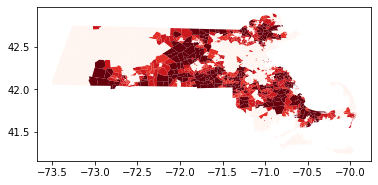

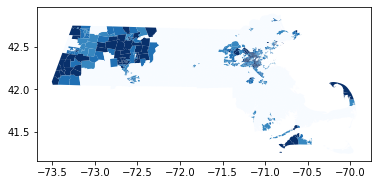

In [121]:
max_partisan_districts("massachusetts", "MA_precincts12_16", 9, "SEN14", 3)

In [84]:
def make_pngs(json_name, shp_name, num_dists, election):
    
    path = os.getcwd()
    os.makedirs(path+"/"+json_name+"/Rep_maps")
    os.makedirs(path+"/"+json_name+"/Dem_maps")
    
    for i in range(num_dists+1):
        max_partisan_districts(json_name, shp_name, num_dists, election, i)

In [115]:
def make_gifs(json_name, length):
    
    path = os.getcwd()
#     print(path)
    # Create the frames
    frames = []
    imgs = glob.glob(path+"/"+json_name+"/Rep_maps/*.png")
    print(imgs[0])
    # Sort the images by #, this may need to be tweaked for your use case
    imgs.sort(key=lambda x: int(x.split('Dists-')[1].split('.png')[0]))
    print(imgs[:0])
    for i in imgs:
        new_frame = Image.open(i)
        frames.append(new_frame)

    # Save into a GIF file that loops forever
    frames[0].save(json_name+'Rep_png_to_gif_'+str(length)+'.gif', format='GIF',
                   append_images=frames[1:],
                   save_all=True,
                   duration=length, loop=0)
    
    # Create the frames
    frames = []
    imgs = glob.glob(path+"/"+json_name+"/Dem_maps/*.png")
    
    # Sort the images by #, this may need to be tweaked for your use case
    imgs.sort(key=lambda x: int(x.split('Dists-')[1].split('.png')[0]))
    
    for i in imgs:
        new_frame = Image.open(i)
        frames.append(new_frame)

    # Save into a GIF file that loops forever
    frames[0].save(json_name+'Dem_png_to_gif_'+str(length)+'.gif', format='GIF',
                   append_images=frames[1:],
                   save_all=True,
                   duration=length, loop=0)

In [117]:
make_gifs("texas", 500)

/Users/gabe/Box Sync/career/mggg_vrdi/Partisan-Metrics/metrics_work_v2/texas/Rep_maps/top_Rep_Dists-0.png
[]


In [99]:
images = ["name_"+str(i)+".png" for i in range(36)]
print(images[:15])

print(images.sort()[:15])


print(images.sort(key=lambda x: int(x.split('_')[1].split('.png')[0]))[:15])

['name_0.png', 'name_1.png', 'name_2.png', 'name_3.png', 'name_4.png', 'name_5.png', 'name_6.png', 'name_7.png', 'name_8.png', 'name_9.png', 'name_10.png', 'name_11.png', 'name_12.png', 'name_13.png', 'name_14.png']


TypeError: 'NoneType' object is not subscriptable

For texas :
The top 0 most Republican quasi-districts possible are [] Republican
The top 0 most Democratic quasi-districts possible are [] Democratic
For texas :
The top 1 most Republican quasi-districts possible are [0.8410830359458935] Republican
The top 1 most Democratic quasi-districts possible are [0.92689152] Democratic
For texas :
The top 2 most Republican quasi-districts possible are [0.8410830359458935, 0.8206928771026722] Republican
The top 2 most Democratic quasi-districts possible are [0.92689152 0.83898715] Democratic
For texas :
The top 3 most Republican quasi-districts possible are [0.8410830359458935, 0.8206928771026722, 0.8118271012268962] Republican
The top 3 most Democratic quasi-districts possible are [0.92689152 0.83898715 0.77414189] Democratic
For texas :
The top 4 most Republican quasi-districts possible are [0.8410830359458935, 0.8206928771026722, 0.8118271012268962, 0.7933810782206697] Republican
The top 4 most Democratic quasi-districts possible are [0.926891

/miniconda3/envs/VRDI/lib/python3.7/site-packages/ipykernel_launcher.py:105: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/miniconda3/envs/VRDI/lib/python3.7/site-packages/geopandas/plotting.py:413: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
/miniconda3/envs/VRDI/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too muc

For texas :
The top 6 most Republican quasi-districts possible are [0.8410830359458935, 0.8206928771026722, 0.8118271012268962, 0.7933810782206697, 0.7863192498345937, 0.7723848560723356] Republican
The top 6 most Democratic quasi-districts possible are [0.92689152 0.83898715 0.77414189 0.75016705 0.73451476 0.70524056] Democratic
For texas :
The top 7 most Republican quasi-districts possible are [0.8410830359458935, 0.8206928771026722, 0.8118271012268962, 0.7933810782206697, 0.7863192498345937, 0.7723848560723356, 0.7561517304269808] Republican
The top 7 most Democratic quasi-districts possible are [0.92689152 0.83898715 0.77414189 0.75016705 0.73451476 0.70524056
 0.68844605] Democratic
For texas :
The top 8 most Republican quasi-districts possible are [0.8410830359458935, 0.8206928771026722, 0.8118271012268962, 0.7933810782206697, 0.7863192498345937, 0.7723848560723356, 0.7561517304269808, 0.7454527017130066] Republican
The top 8 most Democratic quasi-districts possible are [0.92689

For texas :
The top 21 most Republican quasi-districts possible are [0.8410830359458935, 0.8206928771026722, 0.8118271012268962, 0.7933810782206697, 0.7863192498345937, 0.7723848560723356, 0.7561517304269808, 0.7454527017130066, 0.7338584831899921, 0.7150205396634095, 0.6997429035726702, 0.6828522318355502, 0.669137209372068, 0.6468448962676658, 0.6356845666470743, 0.6153341222587922, 0.5983680114553042, 0.5797219518388421, 0.5586511349719461, 0.5359274151496541, 0.5121654886128495] Republican
The top 21 most Democratic quasi-districts possible are [0.92689152 0.83898715 0.77414189 0.75016705 0.73451476 0.70524056
 0.68844605 0.66748171 0.66109625 0.63631967 0.62191335 0.60019658
 0.5726323  0.5446786  0.52077503 0.49494376 0.47003992 0.44805387
 0.42462022 0.40722453 0.38897983] Democratic
For texas :
The top 22 most Republican quasi-districts possible are [0.8410830359458935, 0.8206928771026722, 0.8118271012268962, 0.7933810782206697, 0.7863192498345937, 0.7723848560723356, 0.7561517

For texas :
The top 30 most Republican quasi-districts possible are [0.8410830359458935, 0.8206928771026722, 0.8118271012268962, 0.7933810782206697, 0.7863192498345937, 0.7723848560723356, 0.7561517304269808, 0.7454527017130066, 0.7338584831899921, 0.7150205396634095, 0.6997429035726702, 0.6828522318355502, 0.669137209372068, 0.6468448962676658, 0.6356845666470743, 0.6153341222587922, 0.5983680114553042, 0.5797219518388421, 0.5586511349719461, 0.5359274151496541, 0.5121654886128495, 0.48632300377550813, 0.46146776117308635, 0.4351023552238589, 0.401917568427753, 0.3838236862553898, 0.3677921804827493, 0.3464173652059238, 0.3366638140065611, 0.31806321077234356] Republican
The top 30 most Democratic quasi-districts possible are [0.92689152 0.83898715 0.77414189 0.75016705 0.73451476 0.70524056
 0.68844605 0.66748171 0.66109625 0.63631967 0.62191335 0.60019658
 0.5726323  0.5446786  0.52077503 0.49494376 0.47003992 0.44805387
 0.42462022 0.40722453 0.38897983 0.37119548 0.35531231 0.3354

<Figure size 2304x2304 with 0 Axes>

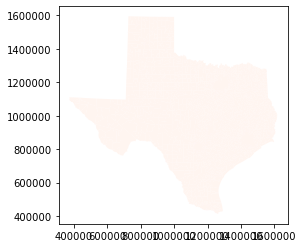

<Figure size 2304x2304 with 0 Axes>

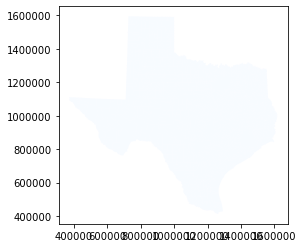

<Figure size 2304x2304 with 0 Axes>

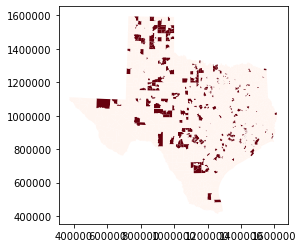

<Figure size 2304x2304 with 0 Axes>

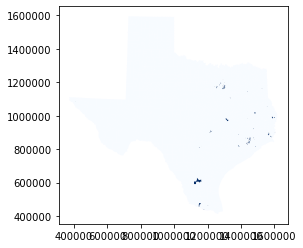

<Figure size 2304x2304 with 0 Axes>

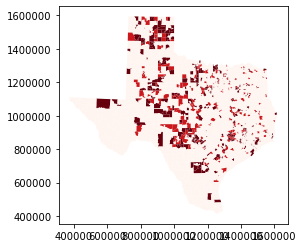

<Figure size 2304x2304 with 0 Axes>

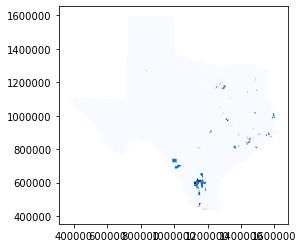

<Figure size 2304x2304 with 0 Axes>

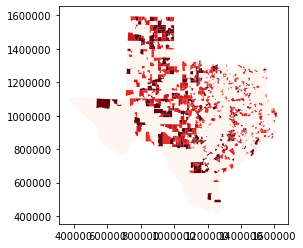

<Figure size 2304x2304 with 0 Axes>

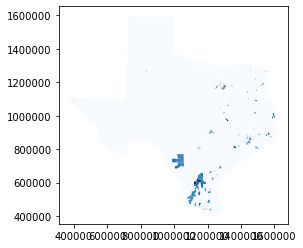

<Figure size 2304x2304 with 0 Axes>

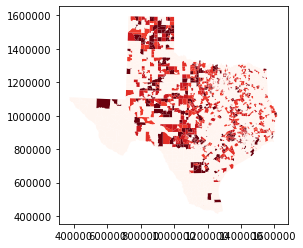

<Figure size 2304x2304 with 0 Axes>

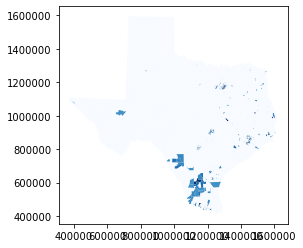

<Figure size 2304x2304 with 0 Axes>

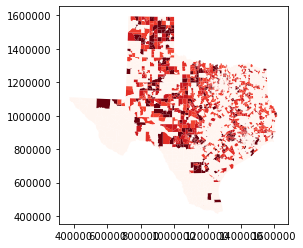

<Figure size 2304x2304 with 0 Axes>

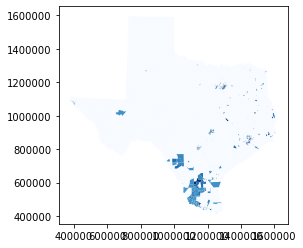

<Figure size 2304x2304 with 0 Axes>

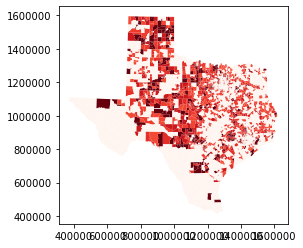

<Figure size 2304x2304 with 0 Axes>

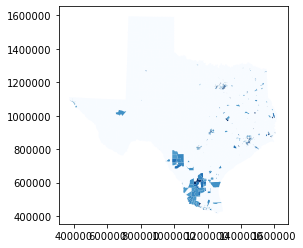

<Figure size 2304x2304 with 0 Axes>

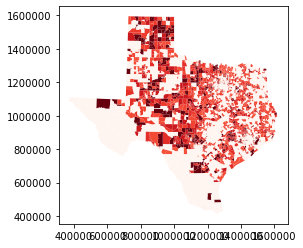

<Figure size 2304x2304 with 0 Axes>

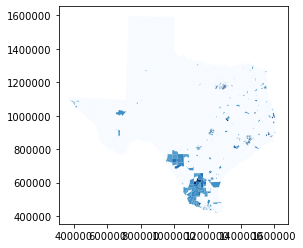

<Figure size 2304x2304 with 0 Axes>

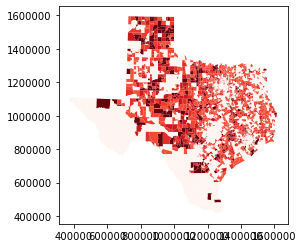

<Figure size 2304x2304 with 0 Axes>

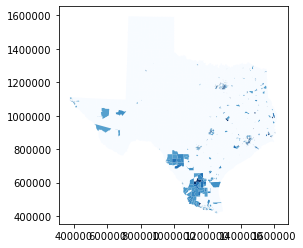

<Figure size 2304x2304 with 0 Axes>

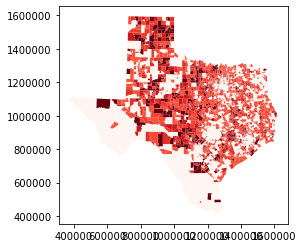

<Figure size 2304x2304 with 0 Axes>

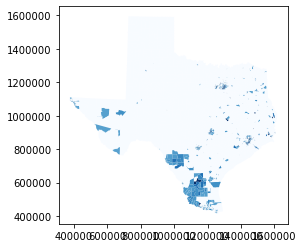

<Figure size 2304x2304 with 0 Axes>

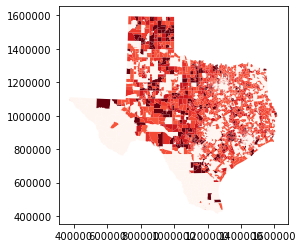

<Figure size 2304x2304 with 0 Axes>

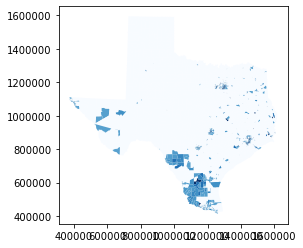

<Figure size 2304x2304 with 0 Axes>

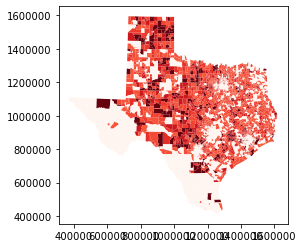

<Figure size 2304x2304 with 0 Axes>

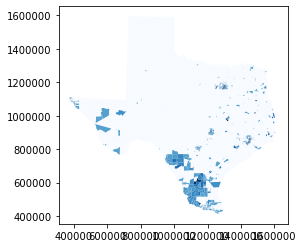

<Figure size 2304x2304 with 0 Axes>

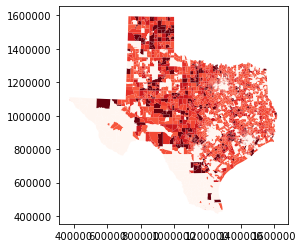

<Figure size 2304x2304 with 0 Axes>

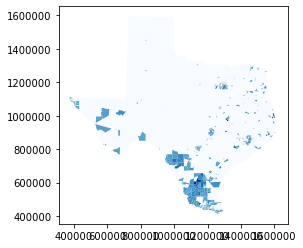

<Figure size 2304x2304 with 0 Axes>

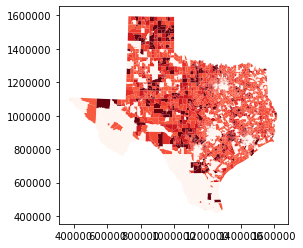

<Figure size 2304x2304 with 0 Axes>

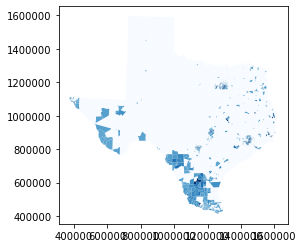

<Figure size 2304x2304 with 0 Axes>

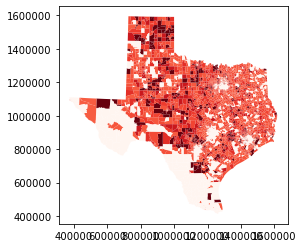

<Figure size 2304x2304 with 0 Axes>

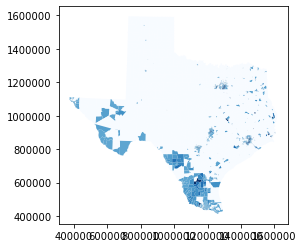

<Figure size 2304x2304 with 0 Axes>

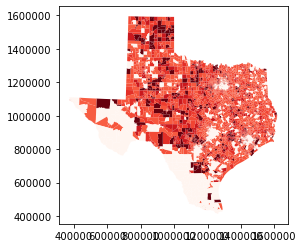

<Figure size 2304x2304 with 0 Axes>

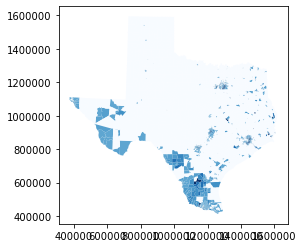

<Figure size 2304x2304 with 0 Axes>

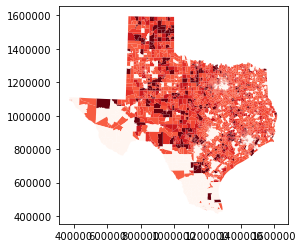

<Figure size 2304x2304 with 0 Axes>

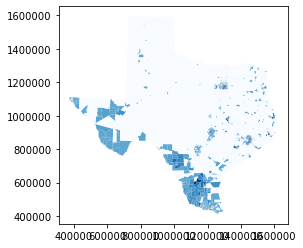

<Figure size 2304x2304 with 0 Axes>

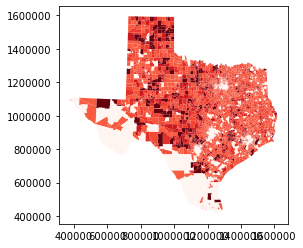

<Figure size 2304x2304 with 0 Axes>

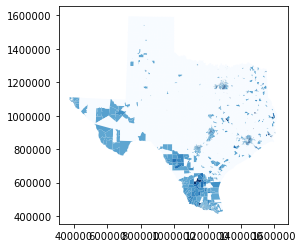

<Figure size 2304x2304 with 0 Axes>

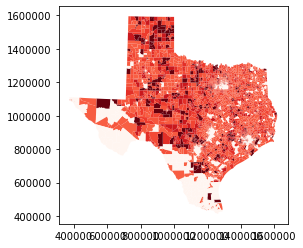

<Figure size 2304x2304 with 0 Axes>

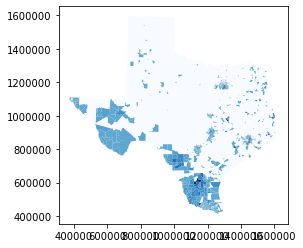

<Figure size 2304x2304 with 0 Axes>

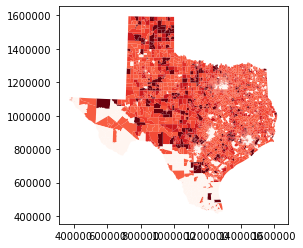

<Figure size 2304x2304 with 0 Axes>

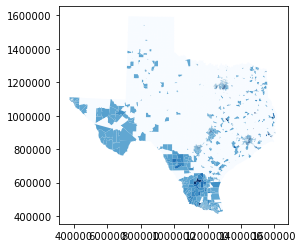

<Figure size 2304x2304 with 0 Axes>

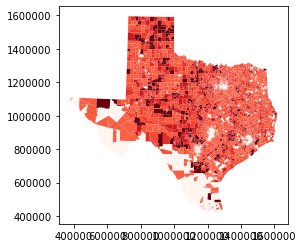

<Figure size 2304x2304 with 0 Axes>

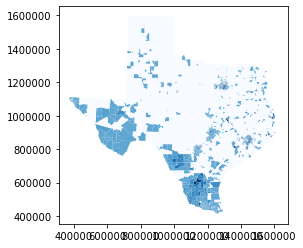

<Figure size 2304x2304 with 0 Axes>

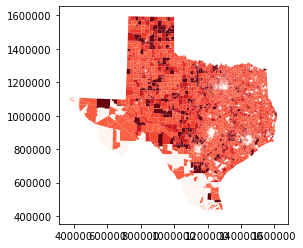

<Figure size 2304x2304 with 0 Axes>

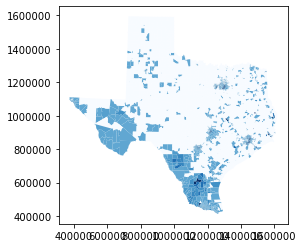

<Figure size 2304x2304 with 0 Axes>

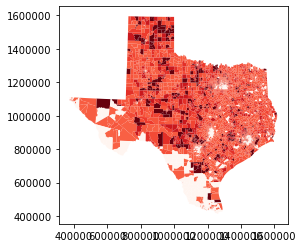

<Figure size 2304x2304 with 0 Axes>

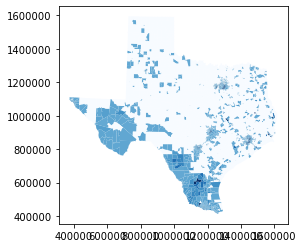

<Figure size 2304x2304 with 0 Axes>

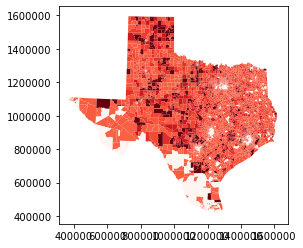

<Figure size 2304x2304 with 0 Axes>

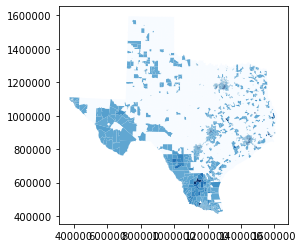

<Figure size 2304x2304 with 0 Axes>

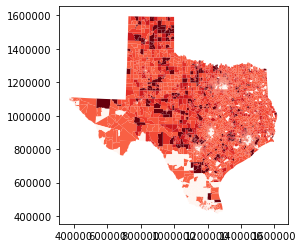

<Figure size 2304x2304 with 0 Axes>

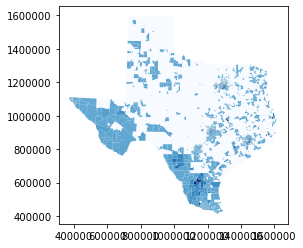

<Figure size 2304x2304 with 0 Axes>

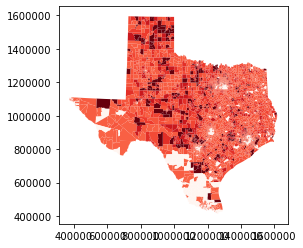

<Figure size 2304x2304 with 0 Axes>

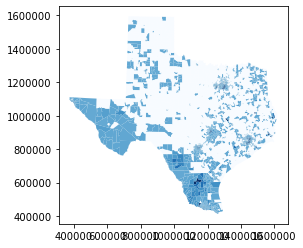

<Figure size 2304x2304 with 0 Axes>

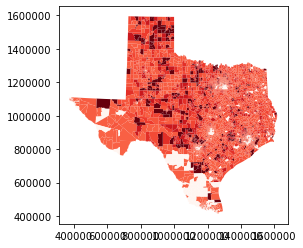

<Figure size 2304x2304 with 0 Axes>

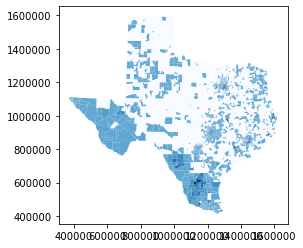

<Figure size 2304x2304 with 0 Axes>

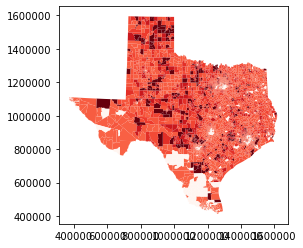

<Figure size 2304x2304 with 0 Axes>

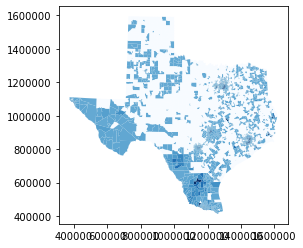

<Figure size 2304x2304 with 0 Axes>

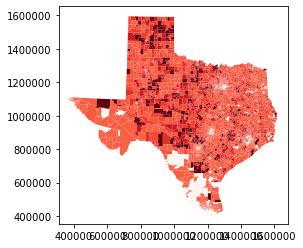

<Figure size 2304x2304 with 0 Axes>

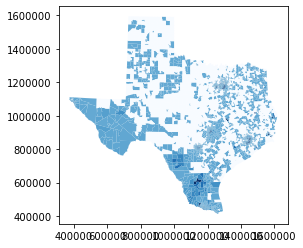

<Figure size 2304x2304 with 0 Axes>

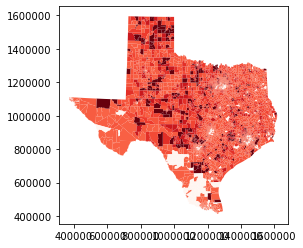

<Figure size 2304x2304 with 0 Axes>

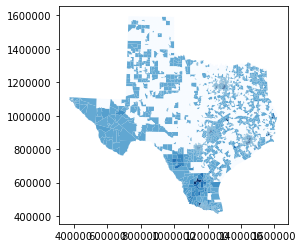

<Figure size 2304x2304 with 0 Axes>

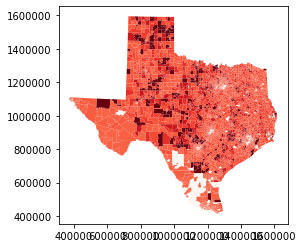

<Figure size 2304x2304 with 0 Axes>

Error in callback <function flush_figures at 0x119faa510> (for post_execute):


KeyboardInterrupt: 

In [88]:
make_pngs("texas", "TX_vtds", 36, "SEN12")

In [105]:
make_gifs("texas", 100)

[]
[]


IndexError: list index out of range

For massachusetts :
The top 3 most Republican quasi-districts possible are [0.5487089422449405, 0.4985101509861911, 0.4593749466021906] Republican
The top 3 most Democratic quasi-districts possible are [0.82191157 0.73548537 0.69303517] Democratic


<Figure size 576x576 with 0 Axes>

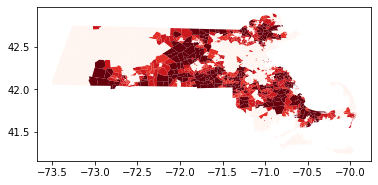

<Figure size 576x576 with 0 Axes>

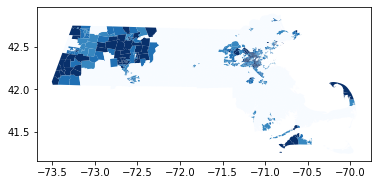

In [23]:
max_partisan_districts("massachusetts", "MA_precincts12_16", 9, "SEN14", 3)

For massachusetts :
The top 2 most Republican quasi-districts possible are [0.5487089422449405, 0.4985101509861911] Republican
The top 2 most Democratic quasi-districts possible are [0.82191157 0.73548537] Democratic


<Figure size 576x576 with 0 Axes>

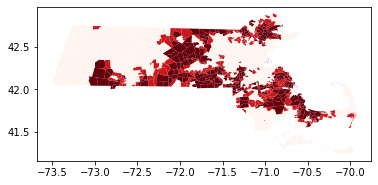

<Figure size 576x576 with 0 Axes>

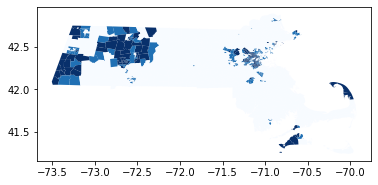

In [238]:
max_partisan_districts("massachusetts", "MA_precincts12_16", 9, "SEN14", 2)

For massachusetts :
The top 3 most Republican quasi-districts possible are [0.5487089422449405, 0.4985101509861911, 0.4593749466021906] Republican
The top 3 most Democratic quasi-districts possible are [0.82191157 0.73548537 0.69303517] Democratic


<Figure size 576x576 with 0 Axes>

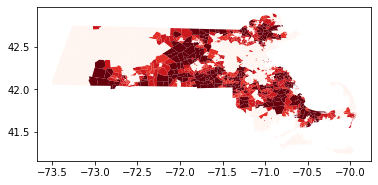

<Figure size 576x576 with 0 Axes>

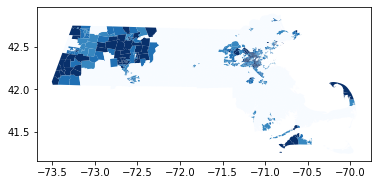

In [256]:
max_partisan_districts("massachusetts", "MA_precincts12_16", 9, "SEN14", 3)

For texas :
The top 1 most Republican quasi-districts possible are [0.8410830359458935] Republican
The top 1 most Democratic quasi-districts possible are [0.92689152] Democratic


<Figure size 576x576 with 0 Axes>

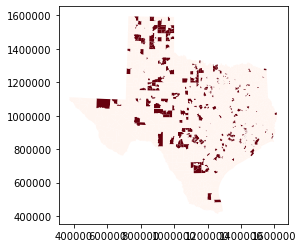

<Figure size 576x576 with 0 Axes>

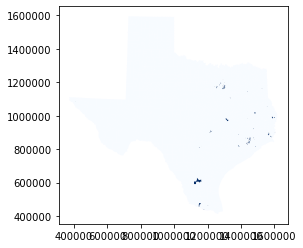

In [234]:
max_partisan_districts("texas", "TX_vtds", 36, "SEN12", 1)

For texas :
The top 2 most Republican quasi-districts possible are [0.8410830359458935, 0.8206928771026722] Republican
The top 2 most Democratic quasi-districts possible are [0.92689152 0.83898715] Democratic


<Figure size 576x576 with 0 Axes>

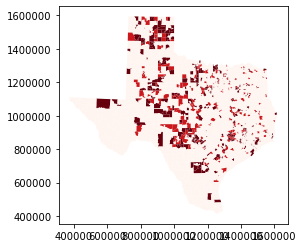

<Figure size 576x576 with 0 Axes>

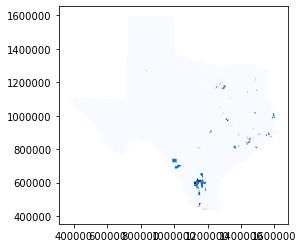

In [5]:
max_partisan_districts("texas", "TX_vtds", 36, "SEN12", 2)

For texas :
The top 3 most Republican quasi-districts possible are [0.8410830359458935, 0.8206928771026722, 0.8118271012268962] Republican
The top 3 most Democratic quasi-districts possible are [0.92689152 0.83898715 0.77414189] Democratic


<Figure size 576x576 with 0 Axes>

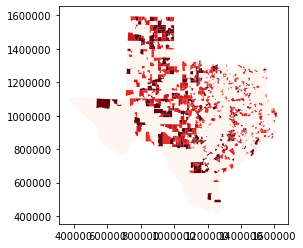

<Figure size 576x576 with 0 Axes>

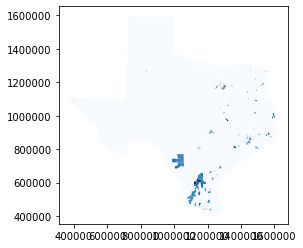

In [6]:
max_partisan_districts("texas", "TX_vtds", 36, "SEN12", 3)

For texas :
The top 10 most Republican quasi-districts possible are [0.8410830359458935, 0.8206928771026722, 0.8118271012268962, 0.7933810782206697, 0.7863192498345937, 0.7723848560723356, 0.7561517304269808, 0.7454527017130066, 0.7338584831899921, 0.7150205396634095] Republican
The top 10 most Democratic quasi-districts possible are [0.92689152 0.83898715 0.77414189 0.75016705 0.73451476 0.70524056
 0.68844605 0.66748171 0.66109625 0.63631967] Democratic


<Figure size 576x576 with 0 Axes>

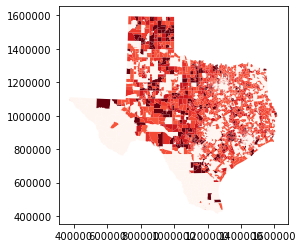

<Figure size 576x576 with 0 Axes>

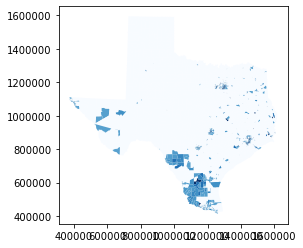

In [8]:
max_partisan_districts("texas", "TX_vtds", 36, "SEN12", 10)

For ri :
The top 1 most Republican quasi-districts possible are [0.4713537893933687] Republican
The top 1 most Democratic quasi-districts possible are [0.71947973] Democratic


<Figure size 576x576 with 0 Axes>

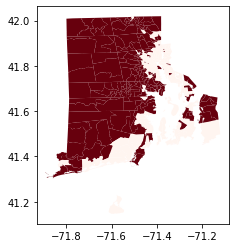

<Figure size 576x576 with 0 Axes>

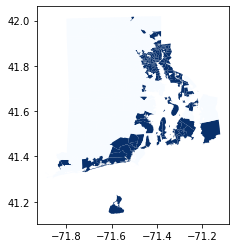

In [229]:
max_partisan_districts("ri", "RI_precincts", 2, "SEN18", 1)

For ri :
The top 2 most Republican quasi-districts possible are [0.4713537893933687, 0.28081057995346237] Republican
The top 2 most Democratic quasi-districts possible are [0.71947973 0.52985854] Democratic


<Figure size 576x576 with 0 Axes>

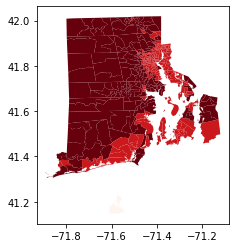

<Figure size 576x576 with 0 Axes>

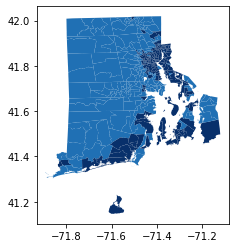

In [231]:
max_partisan_districts("ri", "RI_precincts", 2, "SEN18", 2)

For utah :
The most Republican quasi-district possible is 85.79890859102713 % Republican
The most Democratic quasi-district possible is 57.44144195207663 % Democratic


<Figure size 576x576 with 0 Axes>

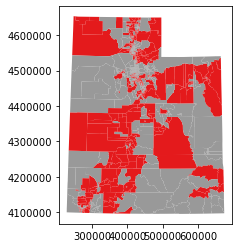

<Figure size 576x576 with 0 Axes>

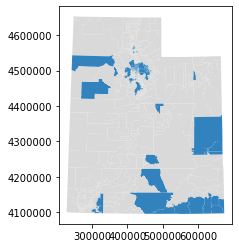

In [127]:
max_partisan_districts("utah", "UT_precincts", 4, "SEN16")

For massachusetts :
The most Republican quasi-district possible is 54.87089422449405 % Republican
The most Democratic quasi-district possible is 82.19115698314639 % Democratic


<Figure size 1008x1008 with 0 Axes>

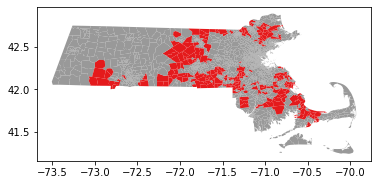

<Figure size 576x576 with 0 Axes>

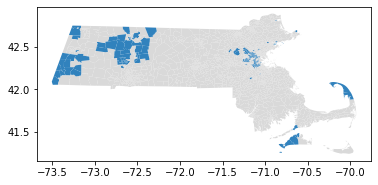

In [124]:
max_partisan_districts("massachusetts", "MA_precincts12_16", 9, "SEN14")

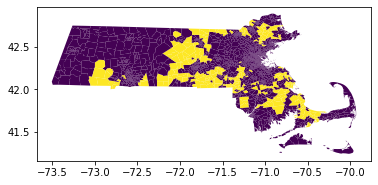

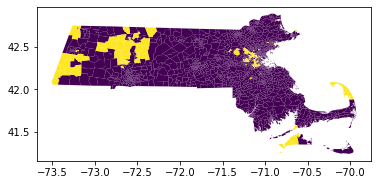

In [93]:
df = gpd.read_file("./MA_precincts12_16.shp")

df["rep_regions"] = df.index.map({x:1 if x in rep_node_list else 0 for x in range(len(graph.nodes))})
df["dem_regions"] = df.index.map({x:1 if x in dem_node_list else 0 for x in range(len(graph.nodes))})

df.plot(column = "rep_regions")
df.plot(column = "dem_regions")

centroids = df.centroid
c_x = centroids.x
c_y = centroids.y

pos = {x: (c_x[x], c_y[x]) for x in graph.nodes}

In [ ]:
# rep_color_map = []
# for node in graph:
#     if node in rep_node_list and node not in dem_node_list:
#         rep_color_map.append('red')
#     else:
#         rep_color_map.append("black")

# # dem_color_map = []
# # for node in graph:
# #     if node in dem_node_list and node not in rep_node_list:
# #         dem_color_map.append('blue')
# #     else:
# #         dem_color_map.append("black")


# plt.figure(1)
# nx.draw_kamada_kawai(graph,
#                     node_size = 10,
#                     node_color = rep_color_map)

# plt.figure(2)
# nx.draw_kamada_kawai(graph,
#                     node_size = 10,
#                     node_color = dem_color_map)

# plt.show()

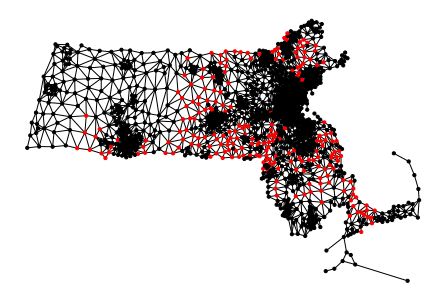

In [85]:
rep_color_map = []
for node in graph:
    if node in rep_node_list and node not in dem_node_list:
        rep_color_map.append('red')
    else:
        rep_color_map.append("black")

nx.draw(graph,
        pos = pos,
        node_size = 10,
        node_color = rep_color_map)

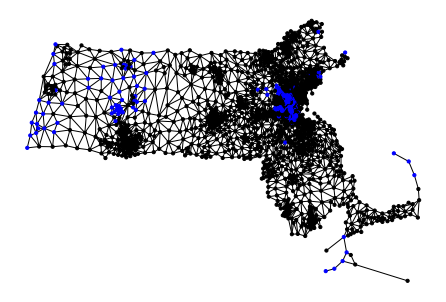

In [87]:
dem_color_map = []
for node in graph:
    if node in dem_node_list and node not in rep_node_list:
        dem_color_map.append('blue')
    else:
        dem_color_map.append("black")

nx.draw(graph,
        pos = pos,
        node_size = 10,
        node_color = dem_color_map)

For massachusetts :
The most Republican quasi-district possible is 54.87089422449405 % Republican
The most Democratic quasi-district possible is 82.19115698314639 % Democratic


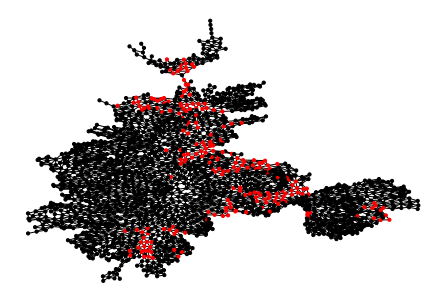

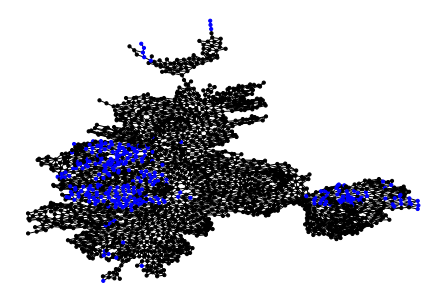

In [53]:
max_partisan_districts("massachusetts", 9, "SEN14")

In [67]:
graph_path = "./massachusetts.json"
plot_path = "./MA_precincts12_16.shp"

df = gpd.read_file(plot_path)

KeyError: ''

In [68]:
centroids = df.centroid

In [ ]:
c_x = centroids.x
c_y = centroids.y
pos = {x: (c_x[x], c_y[y]) for x in graph.nodes}

nx.draw(graph, pos = pos)

In [63]:
unique_label = "Shape_Le_1"

In [66]:
df["plot"] = df[unique_label].map(dict(step.assignment))
df.plot(column="plot", cmap="tab20")
plt.savefig("plot" + ".png")
plt.close()

NameError: name 'step' is not defined

In [61]:
df.columns

Index(['District', 'Name', 'Shape_Le_1', 'Shape_Area', 'City/Town', 'Ward',
       'Pct', 'SEN12D', 'SEN12R', 'PRES12D', 'PRES12R', 'SEN13D', 'SEN13R',
       'SEN14D', 'SEN14R', 'PRES16D', 'PRES16R', 'CD', 'TOTPOP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'HISP',
       'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'VAP',
       'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP',
       '2MOREVAP', 'geometry'],
      dtype='object')

In [62]:
uniqu

District                             Name  Shape_Le_1  Shape_Area  \
0         1-1         Boston Ward 1 Precinct 1    0.237100    0.000684   
1         1-2         Boston Ward 1 Precinct 2    0.020036    0.000023   
2         1-3         Boston Ward 1 Precinct 3    0.041581    0.000044   
3         1-4         Boston Ward 1 Precinct 4    0.032658    0.000027   
4         1-5         Boston Ward 1 Precinct 5    0.040514    0.000049   
5         1-6         Boston Ward 1 Precinct 6    0.033327    0.000026   
6         1-7         Boston Ward 1 Precinct 7    0.028062    0.000018   
7         1-8         Boston Ward 1 Precinct 8    0.029680    0.000032   
8         1-9         Boston Ward 1 Precinct 9    0.036085    0.000034   
9        1-10        Boston Ward 1 Precinct 10    0.033034    0.000034   
10       1-11        Boston Ward 1 Precinct 11    0.058372    0.000098   
11       1-12        Boston Ward 1 Precinct 12    0.113871    0.000141   
12       1-13        Boston Ward 1 Precinct 13    0.055671    0.000048   
13       1-14        Boston Ward 1 Precinct 14    0.053452    0.000073   
14        2-1         Boston Ward 2 Precinct 1    0.058699    0.000077   
15        2-2         Boston Ward 2 Precinct 2    0.088681    0.000115   
16        2-3         Boston Ward 2 Precinct 3    0.020509    0.000018   
17        2-4         Boston Ward 2 Precinct 4    0.016486    0.000013   
18        2-5         Boston Ward 2 Precinct 5    0.022831    0.000016   
19        2-6         Boston Ward 2 Precinct 6    0.022889    0.000023   
20        2-7         Boston Ward 2 Precinct 7    0.087507    0.000117   
21        3-1         Boston Ward 3 Precinct 1    0.042019    0.000029   
22        3-2         Boston Ward 3 Precinct 2    0.026072    0.000018   
23        3-3         Boston Ward 3 Precinct 3    0.025154    0.000013   
24        3-4         Boston Ward 3 Precinct 4    0.015923    0.000011   
25        3-5         Boston Ward 3 Precinct 5    0.044483    0.000086   
26        3-6         Boston Ward 3 Precinct 6    0.063361    0.000123   
27        3-7         Boston Ward 3 Precinct 7    0.025924    0.000033   
28        3-8         Boston Ward 3 Precinct 8    0.044486    0.000105   
29        4-1         Boston Ward 4 Precinct 1    0.015825    0.000014   
...       ...                              ...         ...         ...   
2121        1           Becket Town Precinct 1    0.529124    0.013510   
2122        1           Berlin Town Precinct 1    0.282194    0.003730   
2123        1        Blandford Town Precinct 1    0.487096    0.015082   
2124        1         Chilmark Town Precinct 1    0.590449    0.005725   
2125        1  East Brookfield Town Precinct 1    0.259813    0.002938   
2126        1           Erving Town Precinct 1    0.375257    0.004090   
2127        1          Gosnold Town Precinct 1    0.979578    0.003801   
2128        1          Holland Town Precinct 1    0.250103    0.003680   
2129        1     Lanesborough Town Precinct 1    0.459235    0.008394   
2130        1              Lee Town Precinct 1    0.435283    0.007640   
2131        1      Middlefield Town Precinct 1    0.362277    0.006831   
2132        1         Monterey Town Precinct 1    0.362715    0.007733   
2133        1       Oak Bluffs Town Precinct 1    0.344986    0.002085   
2134        1           Oakham Town Precinct 1    0.332602    0.006005   
2135        1           Rowley Town Precinct 1    0.614068    0.005306   
2136        1          Russell Town Precinct 1    0.316289    0.005008   
2137        1            Savoy Town Precinct 1    0.476296    0.010233   
2138        1      Southampton Town Precinct 1    0.465065    0.008178   
2139        1          Tolland Town Precinct 1    0.401474    0.009240   
2140        1        Tyringham Town Precinct 1    0.308112    0.005333   
2141        1          Warwick Town Precinct 1    0.461224    0.010707   
2142        1       Washington Town Precinct 1    0.502137    0.010982   
2143     

In [39]:
graph = Graph.from_json("massachusetts.json")

In [41]:
len(color_map)

2449

In [42]:
len(graph.nodes)

2151

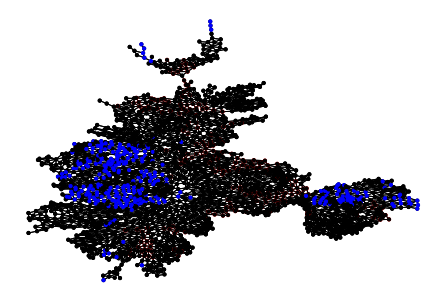

In [49]:
rep_color_map = []
for node in tqdm_notebook(graph):
    if node in rep_node_list and node not in dem_node_list:
        rep_color_map.append('red')
    else:
        rep_color_map.append("black")
        
dem_color_map = []
for node in tqdm_notebook(graph):
    if node in dem_node_list and node not in rep_node_list:
        dem_color_map.append('blue')
    else:
        dem_color_map.append("black")

        
plt.figure(1)
nx.draw_kamada_kawai(graph,
                    node_size = 10,
                    node_color = rep_color_map)

plt.figure(2)
nx.draw_kamada_kawai(graph,
                    node_size = 10,
                    node_color = dem_color_map)

plt.show()

In [25]:
gpd.read_file("MA_precincts12_16.shp")

District                             Name  Shape_Le_1  Shape_Area  \
0         1-1         Boston Ward 1 Precinct 1    0.237100    0.000684   
1         1-2         Boston Ward 1 Precinct 2    0.020036    0.000023   
2         1-3         Boston Ward 1 Precinct 3    0.041581    0.000044   
3         1-4         Boston Ward 1 Precinct 4    0.032658    0.000027   
4         1-5         Boston Ward 1 Precinct 5    0.040514    0.000049   
5         1-6         Boston Ward 1 Precinct 6    0.033327    0.000026   
6         1-7         Boston Ward 1 Precinct 7    0.028062    0.000018   
7         1-8         Boston Ward 1 Precinct 8    0.029680    0.000032   
8         1-9         Boston Ward 1 Precinct 9    0.036085    0.000034   
9        1-10        Boston Ward 1 Precinct 10    0.033034    0.000034   
10       1-11        Boston Ward 1 Precinct 11    0.058372    0.000098   
11       1-12        Boston Ward 1 Precinct 12    0.113871    0.000141   
12       1-13        Boston Ward 1 Precinct 13    0.055671    0.000048   
13       1-14        Boston Ward 1 Precinct 14    0.053452    0.000073   
14        2-1         Boston Ward 2 Precinct 1    0.058699    0.000077   
15        2-2         Boston Ward 2 Precinct 2    0.088681    0.000115   
16        2-3         Boston Ward 2 Precinct 3    0.020509    0.000018   
17        2-4         Boston Ward 2 Precinct 4    0.016486    0.000013   
18        2-5         Boston Ward 2 Precinct 5    0.022831    0.000016   
19        2-6         Boston Ward 2 Precinct 6    0.022889    0.000023   
20        2-7         Boston Ward 2 Precinct 7    0.087507    0.000117   
21        3-1         Boston Ward 3 Precinct 1    0.042019    0.000029   
22        3-2         Boston Ward 3 Precinct 2    0.026072    0.000018   
23        3-3         Boston Ward 3 Precinct 3    0.025154    0.000013   
24        3-4         Boston Ward 3 Precinct 4    0.015923    0.000011   
25        3-5         Boston Ward 3 Precinct 5    0.044483    0.000086   
26        3-6         Boston Ward 3 Precinct 6    0.063361    0.000123   
27        3-7         Boston Ward 3 Precinct 7    0.025924    0.000033   
28        3-8         Boston Ward 3 Precinct 8    0.044486    0.000105   
29        4-1         Boston Ward 4 Precinct 1    0.015825    0.000014   
...       ...                              ...         ...         ...   
2121        1           Becket Town Precinct 1    0.529124    0.013510   
2122        1           Berlin Town Precinct 1    0.282194    0.003730   
2123        1        Blandford Town Precinct 1    0.487096    0.015082   
2124        1         Chilmark Town Precinct 1    0.590449    0.005725   
2125        1  East Brookfield Town Precinct 1    0.259813    0.002938   
2126        1           Erving Town Precinct 1    0.375257    0.004090   
2127        1          Gosnold Town Precinct 1    0.979578    0.003801   
2128        1          Holland Town Precinct 1    0.250103    0.003680   
2129        1     Lanesborough Town Precinct 1    0.459235    0.008394   
2130        1              Lee Town Precinct 1    0.435283    0.007640   
2131        1      Middlefield Town Precinct 1    0.362277    0.006831   
2132        1         Monterey Town Precinct 1    0.362715    0.007733   
2133        1       Oak Bluffs Town Precinct 1    0.344986    0.002085   
2134        1           Oakham Town Precinct 1    0.332602    0.006005   
2135        1           Rowley Town Precinct 1    0.614068    0.005306   
2136        1          Russell Town Precinct 1    0.316289    0.005008   
2137        1            Savoy Town Precinct 1    0.476296    0.010233   
2138        1      Southampton Town Precinct 1    0.465065    0.008178   
2139        1          Tolland Town Precinct 1    0.401474    0.009240   
2140        1        Tyringham Town Precinct 1    0.308112    0.005333   
2141        1          Warwick Town Precinct 1    0.461224    0.010707   
2142        1       Washington Town Precinct 1    0.502137    0.010982   
2143     

{'boundary_node': True,
 'boundary_perim': 0.14079928066162706,
 'area': 0.0006839594270970608,
 'District': '1-1',
 'Name': 'Boston Ward 1 Precinct 1',
 'Shape_Le_1': 0.2370997653,
 'Shape_Area': 0.00068395943,
 'City/Town': 'Boston',
 'Ward': '1',
 'Pct': '1',
 'SEN12D': '604',
 'SEN12R': '251',
 'PRES12D': '645',
 'PRES12R': '188',
 'SEN13D': '241',
 'SEN13R': '84',
 'SEN14D': '439',
 'SEN14R': '109',
 'PRES16D': '755',
 'PRES16R': '189',
 'CD': '07',
 'TOTPOP': 2127.1376074597397,
 'NH_WHITE': 1232.8953012907173,
 'NH_BLACK': 58.91581379295309,
 'NH_AMIN': 11.999999891822892,
 'NH_ASIAN': 66.91581078543187,
 'NH_NHPI': 1.000000016734194,
 'NH_OTHER': 44.747434355389224,
 'HISP': 710.6632473266911,
 'H_WHITE': 428.83162612047374,
 'H_BLACK': 37.00000046135009,
 'H_AMIN': 4.999999662849095,
 'H_ASIAN': 5.999999756691586,
 'H_NHPI': 4.999999786413395,
 'H_OTHER': 228.83162153891337,
 'VAP': 1714.474357046681,
 'HVAP': 502.8316220818222,
 'WVAP': 1071.8952982689327,
 'BVAP': 37.9158133

/miniconda3/envs/VRDI/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


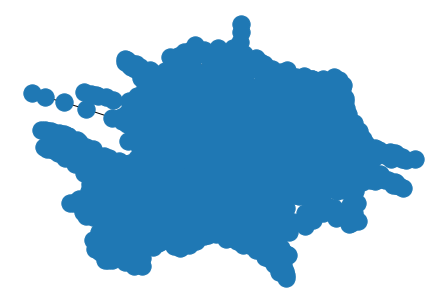

In [23]:
nx.Graph(graph)
nx.draw(graph)

In [136]:
from operator import itemgetter

deltas = [2,3,-5,9]
prec_pop = [100,130,70,96]
ourlist = []
for i in range(len(deltas)):
    ourlist.append((deltas[i], prec_pop[i]))
ourlist.sort(key=lambda x:x[0], reverse=True)
print(ourlist)

# test = zip(deltas, prec_pop)
# sorted(test, reverse=True)
# d = []
# p = []
# for i in test:
#     d.append(i[0])
#     p.append(i[1])
# print(d)
# print(p)

[(9, 96), (3, 130), (2, 100), (-5, 70)]


In [56]:
ascending_DPC = []

for i in range(len(pop_prec)):
    if pop_prec[i] != 0:
        ascending_DPC.append([(dems_prec[i] - reps_prec[i]) / pop_prec[i], i])

In [57]:
len(ascending_DPC)

2151

In [58]:
ascending_DPC[:10]

[[0.15513805916585297, 0],
 [0.08476434853983664, 1],
 [0.11658429409694146, 2],
 [0.05704169941933123, 3],
 [0.06030021301432776, 4],
 [0.05507495868539885, 5],
 [0.06986900144351958, 6],
 [0.08094972551527486, 7],
 [0.07970010748071214, 8],
 [0.0536413364003675, 9]]

In [59]:
ascending_DPC.sort()

In [60]:
ascending_DPC[:10]

[[-0.11742222308712807, 2139],
 [-0.09979575425162523, 483],
 [-0.09854153577032118, 1146],
 [-0.09803887865351182, 600],
 [-0.09737363694990964, 1794],
 [-0.09672432397490777, 2092],
 [-0.09361270636404077, 1157],
 [-0.09277138802468476, 594],
 [-0.0924794033033475, 319],
 [-0.0921568644249277, 1676]]

In [61]:
descending_DPC = ascending_DPC.copy()
descending_DPC.reverse()

In [62]:
descending_DPC[:10]

[[0.5145762918354982, 194],
 [0.45074265408756103, 2030],
 [0.4334006335789255, 196],
 [0.41915852539265136, 2116],
 [0.4124343177682886, 98],
 [0.40581159674896566, 199],
 [0.3867488296432796, 1473],
 [0.3843283622066546, 198],
 [0.3756281370644132, 1447],
 [0.3642433146318682, 2057]]

In [17]:
ascending_DPC[:10]

[[-4.714285714285714, 7829],
 [-3.227777777777778, 6022],
 [-1.9898477157360406, 6023],
 [-1.0338983050847457, 8628],
 [-1.0, 4560],
 [-1.0, 4599],
 [-1.0, 4943],
 [-0.8571428571428571, 5060],
 [-0.8333333333333334, 4709],
 [-0.8085106382978723, 5288]]

In [65]:
I = pop_count/10
print(I)

672816.9714491896


In [66]:
pop_counter = 0
dem_qdist_1 = []
dem_qdist_2 = []

for j in descending_DPC:
    if pop_counter <= I:
        dem_qdist_1.append(j[1])
        pop_counter += graph.nodes[j[1]][TOTPOP]
    elif pop_counter > I and pop_counter <= 2*I:
        dem_qdist_2.append(j[1])
        pop_counter += graph.nodes[j[1]][TOTPOP]
    else:
        break

In [67]:
dem_votes_qdist_1 = 0
rep_votes_qdist_1 = 0
total_pop_qdist_1 = 0
dem_votes_qdist_2 = 0
rep_votes_qdist_2 = 0
total_pop_qdist_2 = 0

for n in dem_qdist_1:
    dem_votes_qdist_1 += graph.nodes[n][DEMVOTE]
    rep_votes_qdist_1 += graph.nodes[n][REPVOTE]
    total_pop_qdist_1 += graph.nodes[n][TOTPOP]
    
for n in dem_qdist_2:
    dem_votes_qdist_2 += graph.nodes[n][DEMVOTE]
    rep_votes_qdist_2 += graph.nodes[n][REPVOTE]
    total_pop_qdist_2 += graph.nodes[n][TOTPOP]
    
votes_qdist_1 = rep_votes_qdist_1 + dem_votes_qdist_1
votes_qdist_2 = rep_votes_qdist_2 + dem_votes_qdist_2

rep_vs_qdist_1 = rep_votes_qdist_1 / votes_qdist_1
rep_vs_qdist_2 = rep_votes_qdist_2 / votes_qdist_2

print(rep_vs_qdist_1, rep_vs_qdist_2)

overall_rep_vs = (rep_votes_qdist_1 + rep_votes_qdist_2) / (votes_qdist_1 + votes_qdist_2)
print(overall_rep_vs)

0.16982165985852346 0.2582378723219999
0.21077508306610301


In [68]:
pop_counter = 0
rep_qdist_1 = []
rep_qdist_2 = []

for j in ascending_DPC:
    if pop_counter <= I:
        rep_qdist_1.append(j[1])
        pop_counter += graph.nodes[j[1]][TOTPOP]
    elif pop_counter > I and pop_counter <= 2*I:
        rep_qdist_2.append(j[1])
        pop_counter += graph.nodes[j[1]][TOTPOP]
    else:
        break

In [69]:
dem_votes_qdist_1 = 0
rep_votes_qdist_1 = 0
total_pop_qdist_1 = 0
dem_votes_qdist_2 = 0
rep_votes_qdist_2 = 0
total_pop_qdist_2 = 0

for n in rep_qdist_1:
    dem_votes_qdist_1 += graph.nodes[n][DEMVOTE]
    rep_votes_qdist_1 += graph.nodes[n][REPVOTE]
    total_pop_qdist_1 += graph.nodes[n][TOTPOP]
    
for n in rep_qdist_2:
    dem_votes_qdist_2 += graph.nodes[n][DEMVOTE]
    rep_votes_qdist_2 += graph.nodes[n][REPVOTE]
    total_pop_qdist_2 += graph.nodes[n][TOTPOP]
    
votes_qdist_1 = rep_votes_qdist_1 + dem_votes_qdist_1
votes_qdist_2 = rep_votes_qdist_2 + dem_votes_qdist_2

rep_vs_qdist_1 = rep_votes_qdist_1 / votes_qdist_1
rep_vs_qdist_2 = rep_votes_qdist_2 / votes_qdist_2

print(rep_vs_qdist_1, rep_vs_qdist_2)

overall_rep_vs = (rep_votes_qdist_1 + rep_votes_qdist_2) / (votes_qdist_1 + votes_qdist_2)
print(overall_rep_vs)

0.5518776477346162 0.5037030633122965
0.5288205390920555


CPU times: user 120 ms, sys: 4.23 ms, total: 125 ms
Wall time: 133 ms


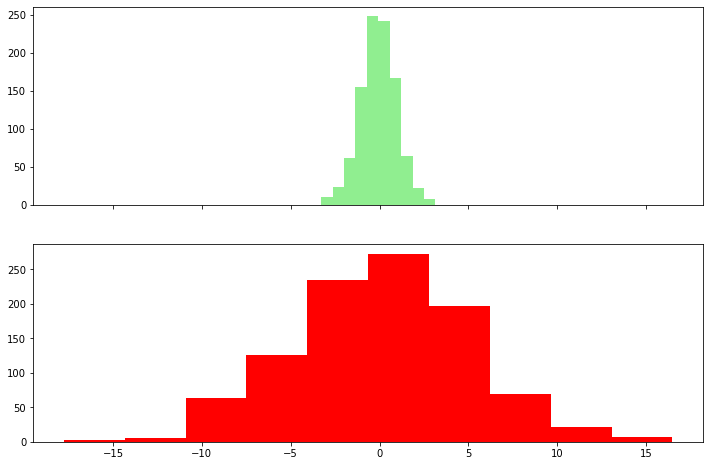

In [101]:
%%time
all_plans = []
outliers = []

colors = ["lightgreen", "red"]

a = np.random.normal(0, 1, 1000)
o = list(np.random.normal(0, 5, 1000))

# for plan in data:
#     all_plans.append(plan)
#     if sorted(plan[3])[-1] > 0.5:
#         outliers.append(plan)
        
fig, pg_compare = plt.subplots(2,1, figsize=(12,8), sharex="col")

pg_compare[0].hist(a, color=colors[0])
pg_compare[1].hist(o, color=colors[1])